# Chapter 13: Performance Reporting

In [39]:
import yfinance as yf

In [40]:
class Allocation:
  def __init__(self, ticker, percentage):
    self.ticker = ticker
    self.percentage = percentage
    self.units = 0.0

class Portfolio:

  def __init__(self, tickerString: str, expectedReturn: float, portfolioName: str, riskBucket: int):

    self.name = portfolioName
    self.riskBucket = riskBucket
    self.expectedReturn = expectedReturn
    self.allocations = []

    from pypfopt.efficient_frontier import EfficientFrontier
    from pypfopt import risk_models
    from pypfopt import expected_returns

    df = self.__getDailyPrices(tickerString, "20y")

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    ef = EfficientFrontier(mu, S)

    ef.efficient_return(expectedReturn)
    self.expectedRisk = ef.portfolio_performance()[1]
    portfolioWeights = ef.clean_weights()

    for key, value in portfolioWeights.items():
      newAllocation = Allocation(key, value)
      self.allocations.append(newAllocation)

  def __getDailyPrices(self, tickerStringList, period):
    data = yf.download(tickerStringList, group_by="Ticker", period=period)
    data = data.iloc[:, data.columns.get_level_values(1)=="Close"]
    data = data.dropna()
    data.columns = data.columns.droplevel(1)
    return data

  def printPortfolio(self):
    print("Portfolio Name: " + self.name)
    print("Risk Bucket: " + str(self.riskBucket))
    print("Expected Return: " + str(self.expectedReturn))
    print("Expected Risk: " + str(self.expectedRisk))
    print("Allocations: ")
    for allocation in self.allocations:
      print("Ticker: " + allocation.ticker + ", Percentage: " + str(allocation.percentage))

  @staticmethod
  def getPortfolioMapping(riskToleranceScore, riskCapacityScore):
    import pandas as pd
    allocationLookupTable=pd.read_csv('./Data/Risk Mapping Lookup.csv')
    matchTol = (allocationLookupTable['Tolerance_min'] <= riskTolScore) & (allocationLookupTable['Tolerance_max'] >= riskTolScore)
    matchCap = (allocationLookupTable['Capacity_min'] <= riskCapScore) & (allocationLookupTable['Capacity_max'] >= riskCapScore)
    portfolioID = allocationLookupTable['Portfolio'][(matchTol & matchCap)]
    return portfolioID.values[0]

In [41]:
# Can use for Goal or Acct level
# Need date, portfoliovalue, cashflow +/-
import pandas as pd
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':110828,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-12-31  110828        0


In [42]:
def calculatePNL_TWRR(history: pd.DataFrame, annualized: bool=False):
  twrr = 1.0
  beginValue = history.iloc[0]['Value']
  for period in range(len(history)-1):
    endValue = history.iloc[period+1]['Value']
    cashflow = history.iloc[period+1]['Cashflow']
    if beginValue > 0.0 or cashflow > 0.0:
      periodReturn = (endValue-(beginValue+cashflow))/(beginValue+cashflow)
      twrr = (1+periodReturn)*twrr
    beginValue = endValue

  twrr = twrr - 1

  if annualized:
    from dateutil import parser
    startDateTime = history.iloc[0].name
    endDateTime = history.iloc[len(history)-1].name
    from dateutil.relativedelta import relativedelta
    delta = relativedelta(endDateTime, startDateTime)
    return twrr/delta.years
  else:
    return twrr

In [43]:
print(calculatePNL_TWRR(history=history))
print(calculatePNL_TWRR(history=history,annualized=True))

0.10827999999999993
0.10827999999999993


In [44]:
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':87985,'Cashflow':10000}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':125039,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-03-23   87985    10000
2020-12-31  125039        0


In [45]:
print(calculatePNL_TWRR(history=history))
#print(calculatePNL_TWRR(history=history,annualized=True))

0.10827600329601639


In [46]:
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':67985,'Cashflow':-10000}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':96616,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-03-23   67985   -10000
2020-12-31   96616        0


In [47]:
print(calculatePNL_TWRR(history=history))

0.1082737015518127


In [48]:
# MWRR: just show formula, not relevant for Robo (hedge funds etc.)

In [49]:
data = yf.download("VTI TLT IEI GLD DBC", group_by="Ticker", period="5y")
data = data.iloc[:, data.columns.get_level_values(1)=="Close"]
data = data.dropna()
data.columns = data.columns.droplevel(1)
data

[*********************100%***********************]  5 of 5 completed


,GLD,DBC,IEI,TLT,VTI
Date,,,,,
2018-01-26 00:00:00-05:00,128.070007,17.250000,120.980003,123.589996,146.860001
2018-01-29 00:00:00-05:00,127.349998,17.200001,120.839996,122.730003,145.899994
2018-01-30 00:00:00-05:00,126.800003,17.080000,120.760002,122.010002,144.380005
2018-01-31 00:00:00-05:00,127.650002,17.100000,120.669998,122.730003,144.429993
2018-02-01 00:00:00-05:00,128.070007,17.270000,120.519997,120.699997,144.369995
...,...,...,...,...,...
2023-01-19 00:00:00-05:00,179.889999,24.940001,117.800003,107.949997,195.020004
2023-01-20 00:00:00-05:00,179.289993,25.090000,117.370003,106.199997,198.759995
2023-01-23 00:00:00-05:00,179.630005,25.150000,117.080002,105.699997,201.279999


In [50]:
data.iloc[0]

GLD    128.070007
DBC     17.250000
IEI    120.980003
TLT    123.589996
VTI    146.860001
Name: 2018-01-26 00:00:00-05:00, dtype: float64

In [51]:
myPortfolio = Portfolio("VTI TLT IEI GLD DBC", expectedReturn = 0.05, portfolioName = "Moderate", riskBucket = 3)

# Manual update using Chapter 12 outputs:
myPortfolio.allocations[0].units = 0.0
myPortfolio.allocations[1].units = 0.02213974051911262
myPortfolio.allocations[2].units = 0.02171626612838836
myPortfolio.allocations[3].units = 0.0163863407640173
myPortfolio.allocations[4].units = 0.009743440233

[*********************100%***********************]  5 of 5 completed


In [52]:
totalValue = 0.0
for allocation in myPortfolio.allocations:
  price = data.iloc[0][allocation.ticker]
  value = allocation.units * price
  print(allocation.ticker + ": " + str(value))
  totalValue += value
print(totalValue)

DBC: 0.0
TLT: 2.7362504496789772
IEI: 2.627233949112487
VTI: 2.4064980146050092
GLD: 1.2478424620033977
9.01782487539987


In [53]:
cashInvested = 0
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':totalValue,'Cashflow':cashInvested}, name=data.iloc[0].name)
history = history.append(new_row)
history

,Value,Cashflow
Date,,
2018-01-26 00:00:00-05:00,9.017825,0.0


In [54]:
totalValue = 0.0
for allocation in myPortfolio.allocations:
  price = data.iloc[len(data)-1][allocation.ticker]
  value = allocation.units * price
  print(allocation.ticker + ": " + str(value))
  totalValue += value
print(totalValue)


DBC: 0.0
TLT: 2.379579385315863
IEI: 2.5514440610333993
VTI: 3.2944738606128214
GLD: 1.764634466545554
9.990131773507636


In [55]:
cashInvested = 0
new_row = pd.Series({'Value':totalValue,'Cashflow':cashInvested}, name=data.iloc[len(data)-1].name)
history = history.append(new_row)
history

,Value,Cashflow
Date,,
2018-01-26 00:00:00-05:00,9.017825,0.0
2023-01-25 00:00:00-05:00,9.990132,0.0


In [56]:
print(calculatePNL_TWRR(history=history))
print(calculatePNL_TWRR(history=history,annualized=True))

0.10782055667993351
0.026955139169983378


In [57]:
# Benchmarking with charts and P&L (TWRR)

In [58]:
#benchmarkPortfolio(None, "SPY", 5)
benchmarkTicker = "SPY"
data = yf.download(benchmarkTicker, group_by="Ticker", period="5y")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-26 00:00:00-05:00,284.250000,286.630005,283.959991,286.579987,263.118591,107743100
2018-01-29 00:00:00-05:00,285.929993,286.429993,284.500000,284.679993,261.374176,90118300
2018-01-30 00:00:00-05:00,282.600006,284.739990,281.220001,281.760010,258.693207,131796400
2018-01-31 00:00:00-05:00,282.730011,283.299988,280.679993,281.899994,258.821777,108364800
2018-02-01 00:00:00-05:00,281.070007,283.059998,280.679993,281.579987,258.527893,90102500
...,...,...,...,...,...,...
2023-01-19 00:00:00-05:00,389.359985,391.079987,387.260010,388.640015,388.640015,86958900
2023-01-20 00:00:00-05:00,390.100006,396.040009,388.380005,395.880005,395.880005,91544900
2023-01-23 00:00:00-05:00,396.720001,402.649994,395.720001,400.630005,400.630005,84178800


In [59]:
data = data.iloc[:, data.columns.get_level_values(0)=="Close"]
data = data.rename(columns={"Close": benchmarkTicker})
data = data.dropna()
data

,SPY
Date,
2018-01-26 00:00:00-05:00,286.579987
2018-01-29 00:00:00-05:00,284.679993
2018-01-30 00:00:00-05:00,281.760010
2018-01-31 00:00:00-05:00,281.899994
2018-02-01 00:00:00-05:00,281.579987
...,...
2023-01-19 00:00:00-05:00,388.640015
2023-01-20 00:00:00-05:00,395.880005
2023-01-23 00:00:00-05:00,400.630005


In [60]:
data[benchmarkTicker] = 100*(data[benchmarkTicker] / data.iloc[0][benchmarkTicker])-100
data

,SPY
Date,
2018-01-26 00:00:00-05:00,0.000000
2018-01-29 00:00:00-05:00,-0.662989
2018-01-30 00:00:00-05:00,-1.681896
2018-01-31 00:00:00-05:00,-1.633049
2018-02-01 00:00:00-05:00,-1.744714
...,...
2023-01-19 00:00:00-05:00,35.613104
2023-01-20 00:00:00-05:00,38.139446
2023-01-23 00:00:00-05:00,39.796924


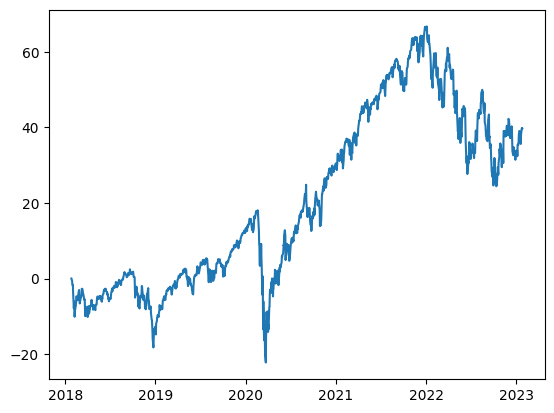

In [61]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.show()

In [62]:
tickerString = ""
portfolio = myPortfolio
years=5

for allocation in portfolio.allocations:
  tickerString = tickerString + allocation.ticker + " "

data2 = yf.download(tickerString, group_by="Ticker", period=str(years)+"y")
data2 = data2.iloc[:, data2.columns.get_level_values(1)=="Close"]
data2 = data2.dropna()
data2.columns = data2.columns.droplevel(1)

[*********************100%***********************]  5 of 5 completed


In [63]:
for allocation in portfolio.allocations:
  data2[allocation.ticker] = data2[allocation.ticker] * allocation.percentage

In [64]:
data2

,DBC,IEI,VTI,TLT,GLD
Date,,,,,
2018-01-26 00:00:00-05:00,0.0,31.937511,44.466271,7.991329,47.204043
2018-01-29 00:00:00-05:00,0.0,31.900551,44.175600,7.935722,46.938662
2018-01-30 00:00:00-05:00,0.0,31.879433,43.715378,7.889167,46.735945
2018-01-31 00:00:00-05:00,0.0,31.855673,43.730513,7.935722,47.049238
2018-02-01 00:00:00-05:00,0.0,31.816074,43.712347,7.804462,47.204043
...,...,...,...,...,...
2023-01-19 00:00:00-05:00,0.0,31.098023,59.048157,6.980047,66.303856
2023-01-20 00:00:00-05:00,0.0,30.984507,60.180551,6.866892,66.082706
2023-01-23 00:00:00-05:00,0.0,30.907950,60.943558,6.834562,66.208027


In [65]:
data2["Total"] = data2[list(data2.columns)].sum(axis=1)
data2["Portfolio"] = 100*(data2["Total"] / data2.iloc[0]["Total"])-100

In [66]:
data2

,DBC,IEI,VTI,TLT,GLD,Total,Portfolio
Date,,,,,,,
2018-01-26 00:00:00-05:00,0.0,31.937511,44.466271,7.991329,47.204043,131.599155,0.000000
2018-01-29 00:00:00-05:00,0.0,31.900551,44.175600,7.935722,46.938662,130.950535,-0.492875
2018-01-30 00:00:00-05:00,0.0,31.879433,43.715378,7.889167,46.735945,130.219923,-1.048055
2018-01-31 00:00:00-05:00,0.0,31.855673,43.730513,7.935722,47.049238,130.571146,-0.781167
2018-02-01 00:00:00-05:00,0.0,31.816074,43.712347,7.804462,47.204043,130.536926,-0.807170
...,...,...,...,...,...,...,...
2023-01-19 00:00:00-05:00,0.0,31.098023,59.048157,6.980047,66.303856,163.430082,24.187791
2023-01-20 00:00:00-05:00,0.0,30.984507,60.180551,6.866892,66.082706,164.114656,24.707986
2023-01-23 00:00:00-05:00,0.0,30.907950,60.943558,6.834562,66.208027,164.894097,25.300271


In [67]:
data2 = data2.filter(['Portfolio'])

In [68]:
data2

,Portfolio
Date,
2018-01-26 00:00:00-05:00,0.000000
2018-01-29 00:00:00-05:00,-0.492875
2018-01-30 00:00:00-05:00,-1.048055
2018-01-31 00:00:00-05:00,-0.781167
2018-02-01 00:00:00-05:00,-0.807170
...,...
2023-01-19 00:00:00-05:00,24.187791
2023-01-20 00:00:00-05:00,24.707986
2023-01-23 00:00:00-05:00,25.300271


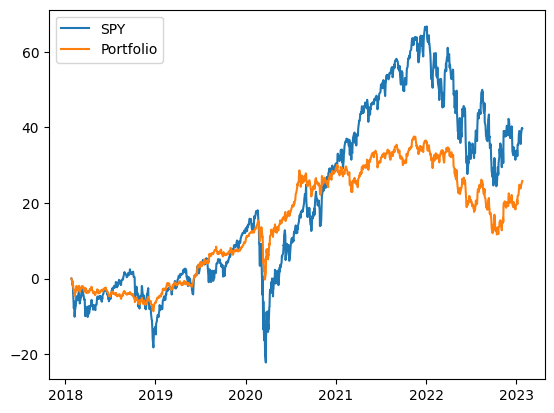

In [69]:
#plt.plot(data)
#plt.plot(data2)
plt.plot(data, label=benchmarkTicker)
plt.plot(data2, label="Portfolio")
plt.legend(loc="upper left")
plt.show()

In [70]:
profitBenchmark = data.iloc[len(data)-1][benchmarkTicker]/100
profitPortfolio = data2.iloc[len(data2)-1]["Portfolio"]/100

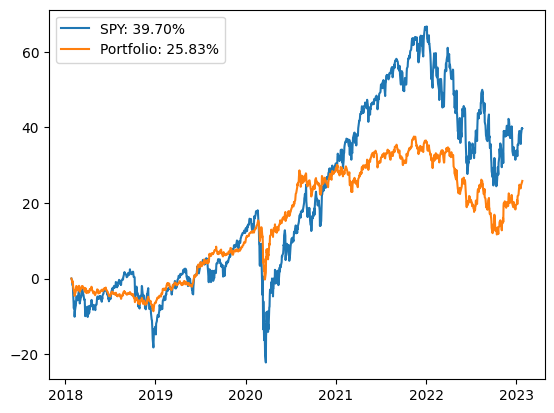

In [71]:
plt.plot(data, label=benchmarkTicker + ": " + '{0:.2f}'.format(profitBenchmark*100) + "%")
plt.plot(data2, label="Portfolio: " + '{0:.2f}'.format(profitPortfolio*100) + "%")
plt.legend(loc="upper left")
plt.show()

In [72]:
def benchmarkPortfolio(portfolio: Portfolio, benchmarkTicker: str, years: int):
  import matplotlib.pyplot as plt 

  # Get Benchmark data
  data = yf.download(benchmarkTicker, group_by="Ticker", period=str(years)+"y")
  data = data.iloc[:, data.columns.get_level_values(0)=="Close"]
  data = data.rename(columns={"Close": benchmarkTicker})
  data = data.dropna()
  data[benchmarkTicker] = 100*(data[benchmarkTicker] / data.iloc[0][benchmarkTicker])-100

  # Get Portfolio data
  tickerString=""
  for allocation in portfolio.allocations:
    tickerString = tickerString + allocation.ticker + " "
  data2 = yf.download(tickerString, group_by="Ticker", period=str(years)+"y")
  data2 = data2.iloc[:, data2.columns.get_level_values(1)=="Close"]
  data2 = data2.dropna()
  data2.columns = data2.columns.droplevel(1)
  for allocation in portfolio.allocations:
    data2[allocation.ticker] = data2[allocation.ticker] * allocation.percentage
  data2["Total"] = data2[list(data2.columns)].sum(axis=1)
  data2["Portfolio"] = 100*(data2["Total"] / data2.iloc[0]["Total"])-100
  data2 = data2.filter(['Portfolio'])

  # Calculate PNL
  profitBenchmark = data.iloc[len(data)-1][benchmarkTicker]/100
  profitPortfolio = data2.iloc[len(data2)-1]["Portfolio"]/100

  # Plot
  plt.plot(data, label=benchmarkTicker + ": " + '{0:.2f}'.format(profitBenchmark*100) + "%")
  plt.plot(data2, label="Portfolio: " + '{0:.2f}'.format(profitPortfolio*100) + "%")
  plt.legend(loc="upper left")
  plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed


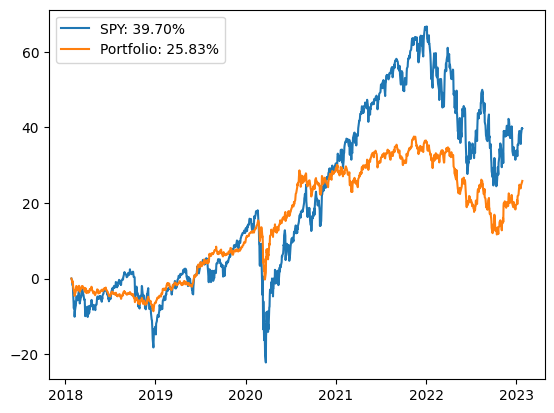

In [73]:
benchmarkPortfolio(portfolio=myPortfolio, benchmarkTicker="SPY", years=5)